In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

df = pd.read_csv(r"data\austin.csv")

In [2]:
listings = df[['price', 
               'host_is_superhost',
               'host_listings_count',
                'accommodates', 
                'bathrooms_text', 
                'beds', 
                'minimum_nights', 
                'maximum_nights', 
                'number_of_reviews', 
                'review_scores_rating', 
                #'property_type'
                ]].copy()
listings.columns

Index(['price', 'host_is_superhost', 'host_listings_count', 'accommodates',
       'bathrooms_text', 'beds', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating'],
      dtype='object')

array([[<Axes: title={'center': 'review_scores_rating'}>]], dtype=object)

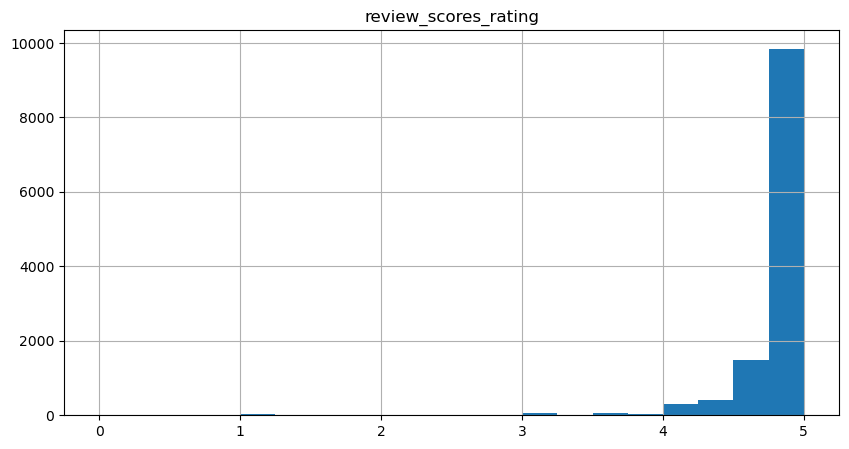

In [75]:
df[['review_scores_rating']].hist(bins=20, figsize=(10, 5))

In [65]:
new_df = df[[
    'host_since', # probably convert this into a number of days
    'neighbourhood_cleansed', # one hot encode this
    'room_type', # one hot encode this
    'minimum_nights',
    'maximum_nights', 
    'minimum_minimum_nights', 
    'maximum_minimum_nights', 
    'minimum_maximum_nights',
    'maximum_maximum_nights', 
    'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm', 
    'availability_30', 
    'availability_60', 
    'availability_90',
    'availability_365', 
    'number_of_reviews_ltm', 
    'number_of_reviews_l30d'
    ]].copy()

In [56]:
def convert_datetime(df):
    col = 'host_since'
    df[col] = pd.to_datetime(df[col])
    return df

In [66]:
new_df = convert_datetime(new_df)

In [67]:
new_df.head()

,host_since,neighbourhood_cleansed,room_type,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews_ltm,number_of_reviews_l30d
0,2009-02-16,78702,Entire home/apt,2,90,2,2,90,90,2.0,90.0,21,51,74,330,47,1
1,2009-02-19,78729,Private room,1,14,1,1,14,14,1.0,14.0,0,0,0,0,20,2
2,2009-04-17,78704,Entire home/apt,30,90,30,30,90,90,30.0,90.0,0,0,0,0,0,0
3,2009-04-20,78704,Entire home/apt,3,365,3,3,1125,1125,3.0,1125.0,10,10,16,160,21,2
4,2009-07-11,78741,Entire home/apt,4,90,4,20,90,90,7.2,90.0,15,45,75,75,3,0


In [69]:
max(new_df['host_since'])

Timestamp('2023-12-11 00:00:00')

In [19]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(listings, test_size=0.2, random_state=42)

listings = train_set.copy()
# does not include longitude and latitude

In [21]:
def clean_price(df):
    #converts price column to floats
    col_name = 'price'
    df = df.copy()
    df[col_name] = df[col_name].str.replace('$','').str.replace(',','')
    df[col_name] = df[col_name].astype(float)
    return df


def clean_bathrooms(df):
    #cleans the bathrooms... har har har... no actually it cleans the bathrooms_text column
    col = 'bathrooms_text'
    df = df.copy()
    pattern = r'(\d.?\d?)\s'
    pattern2 = r'half'
    df.loc[df[col].str.contains(pattern2, case=False, na=False), col] = '0.5 '
    df[col] = df[col].str.extract(pattern)
    df[col] = df[col].astype(float)
    return df


# this may not be necessary, maybe we should keep all these values and use room type as a proxy for property type
#def clean_property_type(df):
    col_name = 'property_type'
    df = df.copy()
    df.loc[df[col_name].str.contains(r'Entire|Tiny home', case=False, na=False), col_name] = 'Entire Unit'
    df.loc[df[col_name].str.contains(r'Shared', case=False, na=False), col_name] = 'Shared Space'
    df.loc[df[col_name].str.contains(r'[Rr]oom', case=False, na=False), col_name] = 'Private Room'
    df.loc[df[col_name].str.contains(r'Camp', case=False, na=False), col_name] = 'Camping Space'

    good_labels = ['Entire Unit', 'Private Room', 'Shared Space', 'Camping Space']
    df.loc[~df[col_name].isin(good_labels), col_name] = 'Other'
    return df



In [22]:
def clean_airbnb(df):
    df = df.copy()
    df = clean_bathrooms(df)
    df = clean_property_type(df)
    return df

In [23]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

num_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

cat_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='if_binary')
)

clean_price_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    FunctionTransformer(np.log1p)
)

mean_imputer = SimpleImputer(strategy='mean')

preprocessing = ColumnTransformer([
    ('cat', cat_pipe, make_column_selector(dtype_include=object)),
    ('num', num_pipe, make_column_selector(dtype_include=np.number))
],
remainder='drop')

In [24]:
y = listings[['price']]
X = listings.drop(columns='price')

In [25]:
y = clean_price(y)
y = mean_imputer.fit_transform(y)

In [26]:
X = clean_airbnb(X)

In [29]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

model = make_pipeline(
    preprocessing,
    TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1)
)

In [32]:
model = make_pipeline(
    preprocessing,
    LinearRegression()
)

In [33]:
model.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000023023049F90>),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000023021F48C10>)])),
                ('linearregression', LinearRegression())])

In [34]:
model.score(X,y)

0.039834774185391386